# Examen de cinturón AML – Opción C
**Descripción del examen:**

En este examen, trabajarás con un dataset de mayor complejidad, aplicando un análisis no supervisado utilizando K-means o PCA para identificar patrones ocultos y luego utilizando un modelo Perceptrón Multicapa (MLP) para realizar predicciones. El examen se centrará en extraer características clave de los datos y aplicar técnicas avanzadas de modelado para realizar predicciones precisas.

**Dataset:**

El dataset utilizado es el «Human Activity Recognition with Smartphones Dataset», que contiene datos recogidos de acelerómetros en smartphones mientras los usuarios realizan actividades cotidianas. El objetivo es clasificar el tipo de actividad física basándose en datos sensoriales de múltiples ejes.
Enlace al dataset: https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

##Funciones a utilizar

In [1]:
# Función para encontrar valores atípicos POR el método de los cuartiles y el rango intercuartílico (IQR). chatgpt
def identificar_atipicos_IQR(df, columnas):
    atipicos = pd.DataFrame()  # DataFrame para almacenar filas con valores atípicos

    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Definir límites para valores atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar filas que tienen valores atípicos
        filas_atipicas = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

        # Concatenar filas atípicas al DataFrame de atípicos
        atipicos = pd.concat([atipicos, filas_atipicas])

    return atipicos.drop_duplicates()  # Eliminar duplicados
def ver_resumen_nulos(df):
    qna=df.isnull().sum(axis=0)
    qsna=df.shape[0]-qna

    ppna=round(100*(qna/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    resumen_nulos =na.sort_values(by='Na en %',ascending=False)
    return resumen_nulos
def desc(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas con el porcentaje de std/mean incluido.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    return df_describe

def desc_ceros(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas filtrando columnas con mínimo o máximo igual a cero,
    e incluye el porcentaje de std/mean.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean para las columnas filtradas.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    # Filtrar las columnas donde el mínimo o el máximo sea igual a cero
    df_describe = df_describe[(df_describe['min'] == 0) | (df_describe['max'] == 0)]

    return df_describe
def imprimir_bigotes(serie):
    """
    Calcula e imprime los bigotes de una serie de datos.

    Parameters:
    serie (pd.Series): La serie de datos para la cual se calcularán los bigotes.

    Returns:
    None: Imprime los valores de los bigotes.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los bigotes
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Límite inferior (bigote inferior): {limite_inferior}")
    print(f"Límite superior (bigote superior): {limite_superior}")
    # Retornar los valores para poder usarlos en otras funciones
    return limite_inferior, limite_superior
def imprimir_bigotes_por_grupo(df, columna, target):
    """
    Imprime los bigotes de los datos por grupo de una columna específica.

    Parameters:
    df (pd.DataFrame): El DataFrame con los datos.
    columna (str): La columna sobre la que se calcularán los bigotes.
    target (str): La columna que contiene las etiquetas de grupo (por ejemplo, 'Species').

    Returns:
    None: Imprime los bigotes por cada grupo.
    """
    print(f"\nBigotes de {columna} por grupo:")
    for species in df[target].unique():
        print(f"\nEspecie: {species}")
        species_data = df[df[target] == species][columna]
        # Imprimir los bigotes solo una vez
        limite_inferior, limite_superior = imprimir_bigotes(species_data)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def plot_varianza(prm_pca,varianza_minima=90):
    plt.figure(figsize=(12, 6))

    # 1. Ganancia de varianza explicada por cada componente
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(prm_pca.explained_variance_ratio_) + 1),
            prm_pca.explained_variance_ratio_, color='skyblue')
    plt.title('Ganancia de varianza explicada por cada componente')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Ganancia de Varianza Explicada (%)')
    plt.grid(True)

    # Etiquetas en las barras
    for i, v in enumerate(prm_pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f'{v*100:.2f}%', ha='center')

    # 2. Varianza acumulada
    explained_variance_cumulative = prm_pca.explained_variance_ratio_.cumsum()
    explained_variance_gain = np.diff(explained_variance_cumulative, prepend=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance_cumulative) + 1),
             explained_variance_cumulative, marker='o', linestyle='--', color='orange')
    plt.title('Variación Explicada Acumulada')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.axhline(y=varianza_minima, color='r', linestyle='--', label=f'{varianza_minima*100}% Umbral')
    plt.axvline(x=np.argmax(explained_variance_cumulative >= varianza_minima) + 1,
                color='g', linestyle='--', label='Número óptimo de componentes')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Mostrar información en consola
    print("Variación explicada acumulada y ganancia:")
    for i, variance in enumerate(explained_variance_cumulative, 1):
        variance_rounded = round(variance, 4)
        print(f"variance_rounded: {variance_rounded}")
        if variance_rounded < 1:
            print(f"Componente {i}: {variance:.2%} ({explained_variance_gain[i-1]*100:.2f}%)")
        else:
          print(f"Existen mas componentes pero ya no aportan variabilidad significativa o es muy infima.")
          break

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)




##Instrucciones:
1. Exploración y preprocesamiento de datos:
  - Carga y explora el dataset, identificando las variables relacionadas con los datos sensoriales. Este conjunto de datos incluye lecturas de aceleración en los ejes X, Y y Z mientras los sujetos realizan actividades como caminar, correr, y subir escaleras.
  - Asegúrate de manejar cualquier valor nulo, normalizando las lecturas sensoriales para mejorar el rendimiento del análisis y el modelado posterior.

In [2]:
#import os
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d uciml/human-activity-recognition-with-smartphones
#import zipfile

## Extraer el contenido
#with zipfile.ZipFile("human-activity-recognition-with-smartphones.zip", 'r') as zip_ref:
#   zip_ref.extractall("human_activity_data")

In [3]:
!ls human_activity_data


test.csv  train.csv


In [4]:
import pandas as pd
# Acceder al archivo
file_path = '/content/human_activity_data/train.csv'
df_train = pd.read_csv(file_path)
print(df_train.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [5]:
file_path = '/content/human_activity_data/test.csv'
df_test = pd.read_csv(file_path)
print(df_test.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   
2           0.275485          -0.026050          -0.118152         -0.993819   
3           0.270298          -0.032614          -0.117520         -0.994743   
4           0.274833          -0.027848          -0.129527         -0.993852   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   
2         -0.969926         -0.962748         -0.994403         -0.970735   
3         -0.973268         -0.967091         -0.995274         -0.974471   
4         -0.967445         -0.978295         -0.994111         -0.965953   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [7]:
ver_resumen_nulos(df_train)

,datos sin NAs en q,Na en q,Na en %
tBodyAcc-mean()-X,7352,0,0.0
fBodyAccJerk-kurtosis()-Y,7352,0,0.0
fBodyAccJerk-meanFreq()-X,7352,0,0.0
fBodyAccJerk-meanFreq()-Y,7352,0,0.0
fBodyAccJerk-meanFreq()-Z,7352,0,0.0
...,...,...,...
tBodyGyroJerk-iqr()-Z,7352,0,0.0
tBodyGyroJerk-iqr()-Y,7352,0,0.0
tBodyGyroJerk-iqr()-X,7352,0,0.0
tBodyGyroJerk-energy()-Z,7352,0,0.0


Wow, 563 columnas.
NO hay nulos.



In [8]:
df = df_train.copy()

In [9]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
df[yes_no_columns] = pd.DataFrame(
    map(lambda col: df[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': []


In [10]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [11]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

""


No hay registros tipo objec como categorias.

In [12]:
import pandas as pd

def find_columns_in_range(df, min_val=0, max_val=255):
  """
  Encuentra las columnas en un DataFrame donde todos los valores numéricos están dentro del rango especificado.

  Args:
    df: El DataFrame de Pandas.
    min_val: El valor mínimo del rango.
    max_val: El valor máximo del rango.

  Returns:
    Una lista con los nombres de las columnas que cumplen la condición.
  """

  columns_in_range = []
  for col in df.select_dtypes(include=['number']).columns:
    if (df[col].min() >= min_val) and (df[col].max() <= max_val):
      columns_in_range.append(col)
  return columns_in_range

# Ejemplo de uso:
df = pd.DataFrame({'columna1': [0, 100, 255],
                   'columna2': [-10, 50, 100],
                   'columna3': [128, 255, 0]})

columns_in_range = find_columns_in_range(df)
print(columns_in_range)  # Output: ['columna1', 'columna3']

['columna1', 'columna3']


In [13]:
# Al revisar los outliers salio un mensaje PerformanceWarning: DataFrame is highly fragmented.
#df = df.reset_index(drop=True) No funciono
df = pd.concat([df], axis=1)  # Reconstruye y reduce la fragmentación


In [14]:
import pandas as pd

#Para evitar que el Warning de fragmentación llene la pantalla en Colab o Jupyter, puedes suprimir los warnings utilizando las siguientes líneas:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Copia profunda para evitar fragmentación
df = df_train.copy(deep=True)

In [15]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T


,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
tBodyAcc-mean()-X,1795.0,24.415125,0.224801,0.326680
tBodyAcc-mean()-Y,1122.0,15.261153,-0.045966,0.010298
tBodyAcc-mean()-Z,1180.0,16.050054,-0.155740,-0.063160
tBodyAcc-std()-X,2.0,0.027203,-1.000000,0.876942
tBodyAcc-std()-Y,0.0,0.000000,-0.999873,0.916238
...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",0.0,0.000000,-1.000000,0.996078
"angle(X,gravityMean)",1437.0,19.545702,-1.000000,-0.059128
"angle(Y,gravityMean)",776.0,10.554951,-0.411559,0.478157
"angle(Z,gravityMean)",705.0,9.589227,-0.519104,0.481737


In [16]:
# Filtrar columnas no numéricas
columnas_no_numericas = df.select_dtypes(exclude=['number']).columns

# Mostrar las columnas no numéricas
print(columnas_no_numericas)


Index(['Activity'], dtype='object')


In [17]:
df['Activity'].value_counts()
#

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [18]:
from sklearn.preprocessing import LabelEncoder

# Identificar las columnas no numéricas
non_numeric_cols = df.select_dtypes(include='object').columns

# Aplicar LabelEncoder, convertir a integer y reemplazar las columnas originales
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    df[col] = label_encoder.fit_transform(df[col]).astype('int32')

# Verificar el tipo de datos y el resultado
print(df.dtypes)
print(df.head())


tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                  int32
Length: 563, dtype: object
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112        

No se si debo aplicar normalización.

In [19]:
desc(df)

,count,mean,std,min,25%,50%,75%,max,%std/mean
tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000,25.60
tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000,-230.63
tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000,-51.89
tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000,-74.12
tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238,-98.38
...,...,...,...,...,...,...,...,...,...
"angle(X,gravityMean)",7352.0,-0.489547,0.511807,-1.000000,-0.812065,-0.709417,-0.509079,1.000000,-104.55
"angle(Y,gravityMean)",7352.0,0.058593,0.297480,-1.000000,-0.017885,0.182071,0.248353,0.478157,507.71
"angle(Z,gravityMean)",7352.0,-0.056515,0.279122,-1.000000,-0.143414,0.003181,0.107659,1.000000,-493.89
subject,7352.0,17.413085,8.975143,1.000000,8.000000,19.000000,26.000000,30.000000,51.54


# Los datos Activity y Subject no seran parte del PCA debido a:
- Activity: Se desea encontrar los cluster para identificar dichas actividades.
- Subject: No es necesario identificar a los sujetos de la prueba.

# Los datos van desde -1 a 1. Pero hay muchos outliers.
No pienso eliminarlos, por lo que voy a aplicar el escalamiento.

## Identificar las variables sensoriales

In [20]:
# Buscar todas las columnas que contienen datos sensoriales (aceleración en los ejes X, Y, Z)
# Filtrar las columnas que contienen 'Acc' y terminan con '-X', '-Y', o '-Z'
sensor_columns = [col for col in df.columns if 'Acc' in col and (col.endswith('-X') or col.endswith('-Y') or col.endswith('-Z'))]

# Ver las columnas encontradas
print(sensor_columns)



['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tGravityAcc-mad()-X', 'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X', 'tGravityAcc-energy()-Y', 'tGravityAcc-energy()-Z', 'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z', 

- Explorar los datos sensoriales

In [21]:
# Mostrar estadísticas descriptivas para las columnas sensoriales
desc(df, sensor_columns)


,count,mean,std,min,25%,50%,75%,max,%std/mean
tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000,25.60
tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000,-230.63
tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000,-51.89
tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000,-74.12
tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238,-98.38
...,...,...,...,...,...,...,...,...,...
fBodyAccJerk-kurtosis()-X,7352.0,-0.715568,0.210373,-1.000000,-0.858751,-0.776195,-0.639955,0.660042,-29.40
fBodyAccJerk-skewness()-Y,7352.0,-0.396125,0.190546,-1.000000,-0.535100,-0.417467,-0.287906,1.000000,-48.10
fBodyAccJerk-kurtosis()-Y,7352.0,-0.819666,0.143524,-1.000000,-0.912602,-0.855798,-0.771686,1.000000,-17.51
fBodyAccJerk-skewness()-Z,7352.0,-0.486687,0.202703,-1.000000,-0.628908,-0.520183,-0.382036,1.000000,-41.65


Al revisar las estadísticas, la desviación standard sobre el promedio el valor absoluto es mayor al 20%. No es normal.

Correlación entre los ejes X, Y, Z

In [22]:
# Mostrar la matriz de correlación de las columnas sensoriales
df[sensor_columns].corr()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyAccJerk-maxInds-Z,fBodyAccJerk-meanFreq()-X,fBodyAccJerk-meanFreq()-Y,fBodyAccJerk-meanFreq()-Z,fBodyAccJerk-skewness()-X,fBodyAccJerk-kurtosis()-X,fBodyAccJerk-skewness()-Y,fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-skewness()-Z,fBodyAccJerk-kurtosis()-Z
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.059457,0.025839,0.027617,0.051235,0.023432,0.031736,0.000359,0.002302,0.001506,-0.005306
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,0.015294,0.037400,0.024103,0.018403,-0.021027,-0.014234,-0.003049,0.004788,0.013985,0.021651
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.000517,0.017089,0.001284,0.023351,-0.017889,-0.022673,-0.009649,-0.007489,0.014983,0.028535
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.262681,-0.743723,-0.560176,-0.501756,0.600666,0.525382,0.444368,0.315811,0.391055,0.277051
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.313105,-0.755366,-0.631853,-0.571237,0.561756,0.460159,0.513957,0.386227,0.436901,0.320855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fBodyAccJerk-kurtosis()-X,0.031736,-0.014234,-0.022673,0.525382,0.460159,0.429459,0.535335,0.461120,0.432304,0.476463,...,-0.206859,-0.432048,-0.319135,-0.333534,0.947871,1.000000,0.304631,0.237605,0.338009,0.276858
fBodyAccJerk-skewness()-Y,0.000359,-0.003049,-0.009649,0.444368,0.513957,0.445972,0.444616,0.511977,0.450154,0.436777,...,-0.199785,-0.457566,-0.466794,-0.383671,0.387403,0.304631,1.000000,0.933558,0.390240,0.334663
fBodyAccJerk-kurtosis()-Y,0.002302,0.004788,-0.007489,0.315811,0.386227,0.334349,0.317223,0.385065,0.337626,0.308978,...,-0.146355,-0.328276,-0.318256,-0.275678,0.298901,0.237605,0.933558,1.000000,0.318843,0.287559
fBodyAccJerk-skewness()-Z,0.001506,0.013985,0.014983,0.391055,0.436901,0.453939,0.393935,0.431915,0.459251,0.386232,...,-0.211805,-0.401279,-0.313243,-0.383558,0.410709,0.338009,0.390240,0.318843,1.000000,0.934905


Visualización de los datos sensoriales

In [23]:
# Ver cuántas columnas sensoriales hay
print(len(sensor_columns))



144


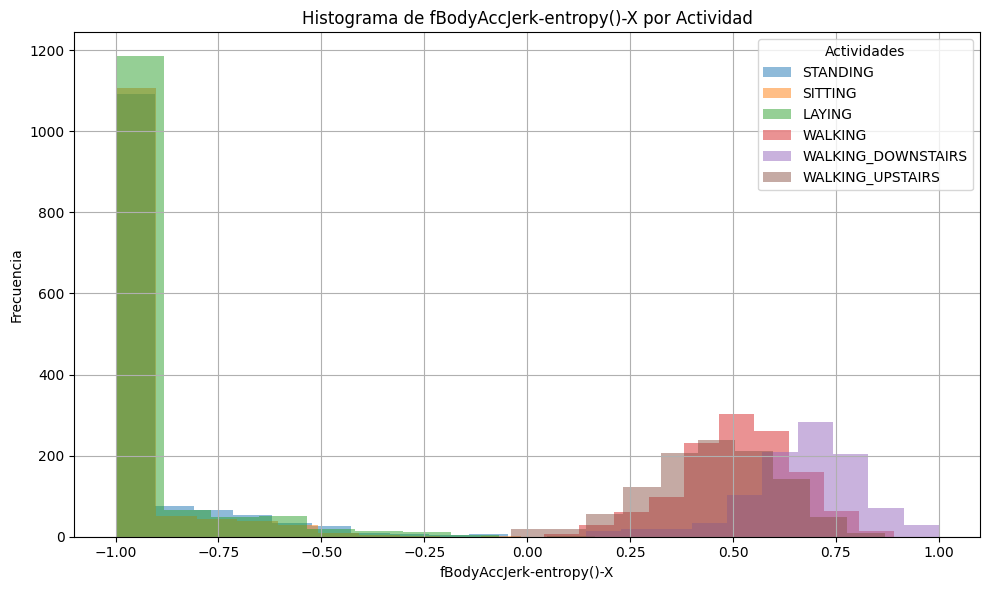

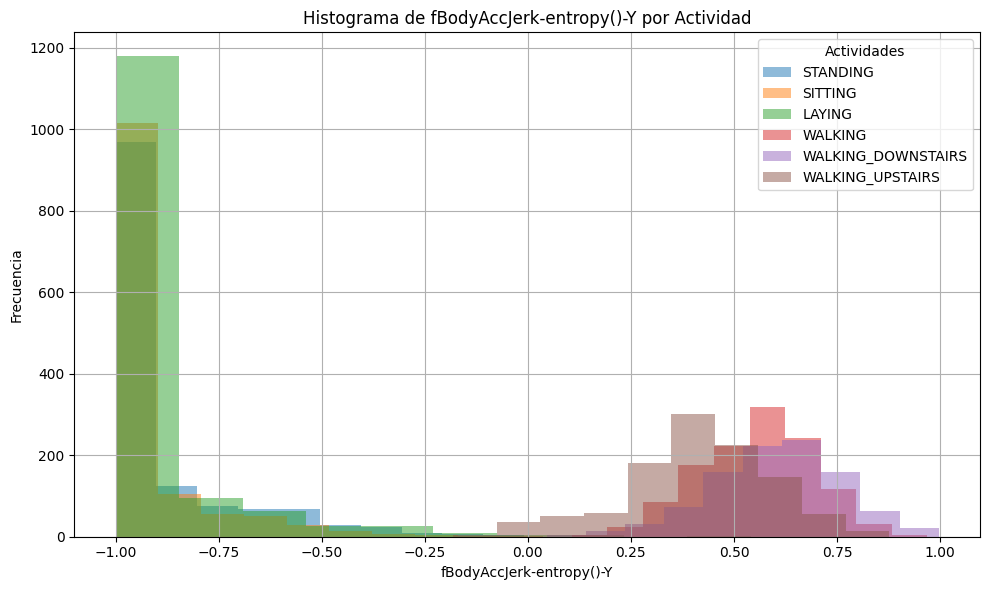

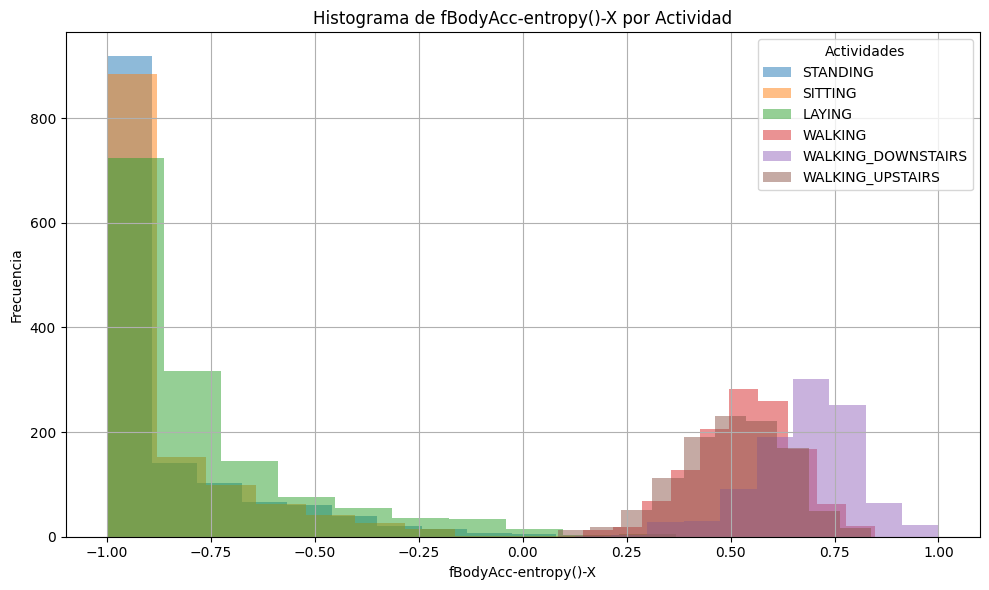

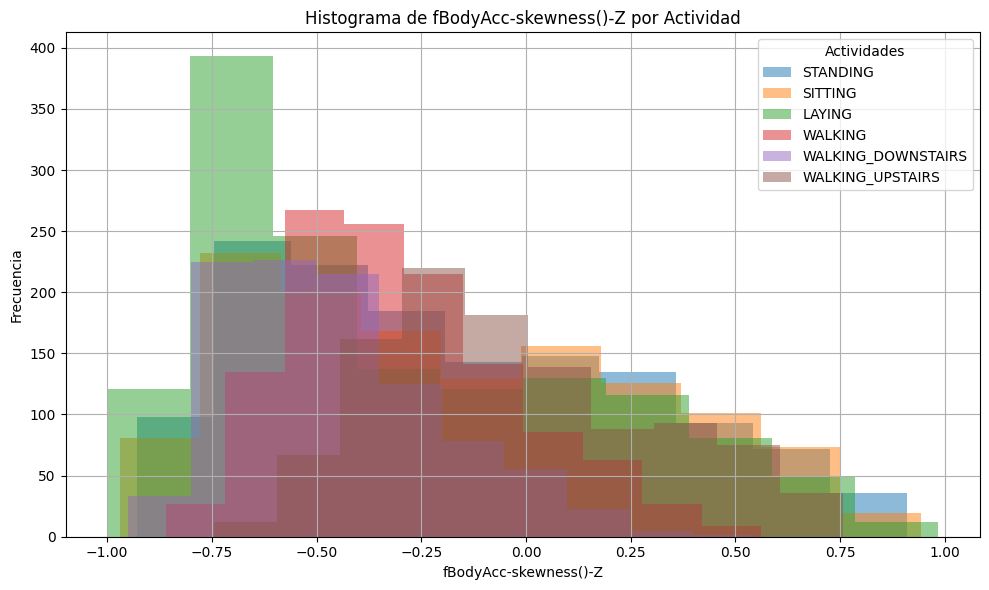

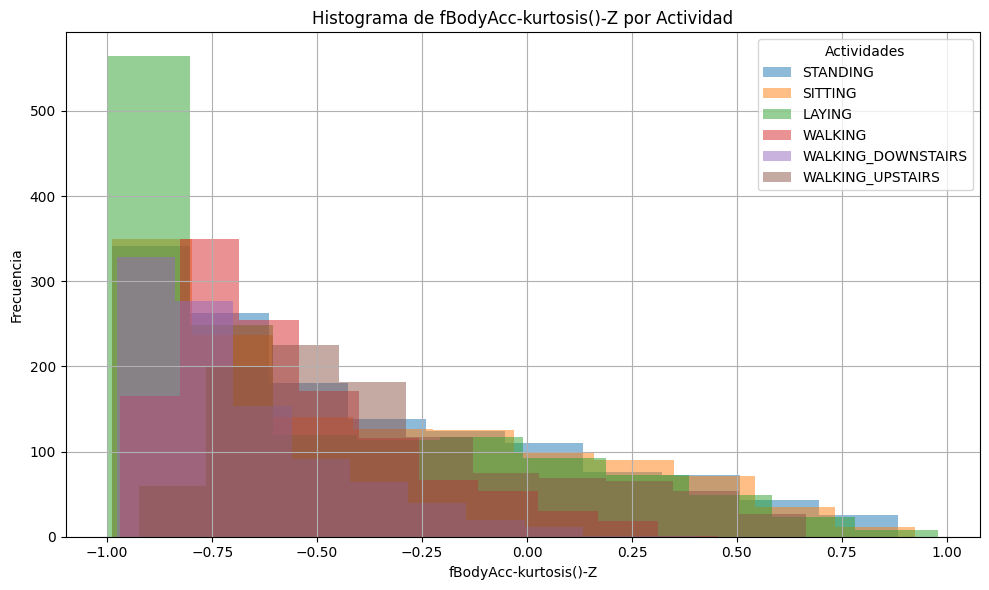

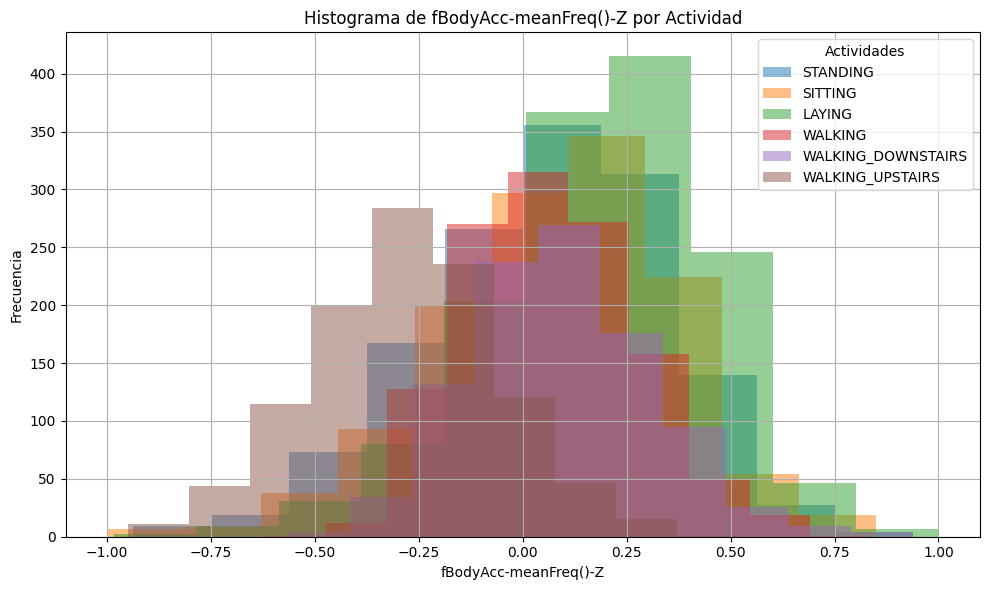

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista de variables que quieres graficar
variables = [
    'fBodyAccJerk-entropy()-X',
    'fBodyAccJerk-entropy()-Y',
    'fBodyAcc-entropy()-X',
    'fBodyAcc-skewness()-Z',
    'fBodyAcc-kurtosis()-Z',
    'fBodyAcc-meanFreq()-Z'
]

# Función para graficar histogramas por actividad
def plot_histograms(df, variables, activity_column):
    activities = df[activity_column].unique()  # Obtener las actividades únicas
    for var in variables:
        plt.figure(figsize=(10, 6))
        for activity in activities:
            # Filtrar los datos por actividad
            activity_data = df[df[activity_column] == activity][var]
            # Graficar el histograma para esa actividad
            plt.hist(activity_data, bins=10, alpha=0.5, label=activity)

        # Configuración del gráfico
        plt.title(f'Histograma de {var} por Actividad')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.legend(title='Actividades')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Llamada a la función para generar los histogramas
plot_histograms(df_train, variables, 'Activity')


- Se ve un sesgo notorio a la izquierda para fBodyAccJerk-entropy()-x para la
actividad Laying para valores negetivos (-1)
- Se ve un sesgo notorio a la izquierda para fBodyAccJerk-entropy()-Y para la actividad Laying para valores negetivos (-1)
- Se ve un sesgo notorio a la izquierda para fBodyAcc-entropy()-X para Standing, Sitting y Laying para valores negetivos (-1)
- Para fBodyAcc-menaFreq()-Z parace normalizado para Laying y Walking para el valor cero.


##2. Análisis no supervisado:
PCA: Si eliges PCA, realiza una reducción de dimensionalidad para identificar los componentes principales que explican la mayor variabilidad en los datos sensoriales. Visualiza los datos en el espacio reducido de los componentes principales.

Voy por el 95% de variabilidad.

Los outliers son bastante grandes por lo que voy a probar primero con RobustScaler.

In [25]:
# Escalar los datos para tener media 0 y desviación estándar 1
from sklearn.preprocessing import RobustScaler
X = df.drop(columns=['Activity','subject'])
y = df['Activity']
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_scaled.mean(axis=0)[:5]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_scaled.std(axis=0)[:5]}")

Resumen de datos escalados:
Media por característica (aproximadamente 0): [-0.10614618 -0.03382691 -0.02003386  0.45437972  0.36122448]
Desviación estándar por característica (aproximadamente 1): [2.75668408 2.8982715  2.44108645 0.59831896 0.53248386]


In [26]:
# Paso 2: Aplicar PCA
from sklearn.decomposition import PCA
# Definir la variabilidad minima objetivo
variabilidad_minima = 0.95
pca = PCA(n_components=None)# Indica que se deja así para determinar el numero de componentes optimo. He Probado y funciona por eso lo uso.
pca.fit(X_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_scaled)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 95% de la variabilidad
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 95% de la varianza
num_components = (cumulative_variance >= variabilidad_minima).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {num_components} componentes para capturar al menos el 95% de la variabilidad.")
print(f"Varianza acumulada: {cumulative_variance[num_components - 1]:.4f}")

Se necesitan 63 componentes para capturar al menos el 95% de la variabilidad.
Varianza acumulada: 0.9509


- Visualiza el gráfico de «explained variance» para mostrar cómo cada componente principal contribuye a la variabilidad total de los datos.



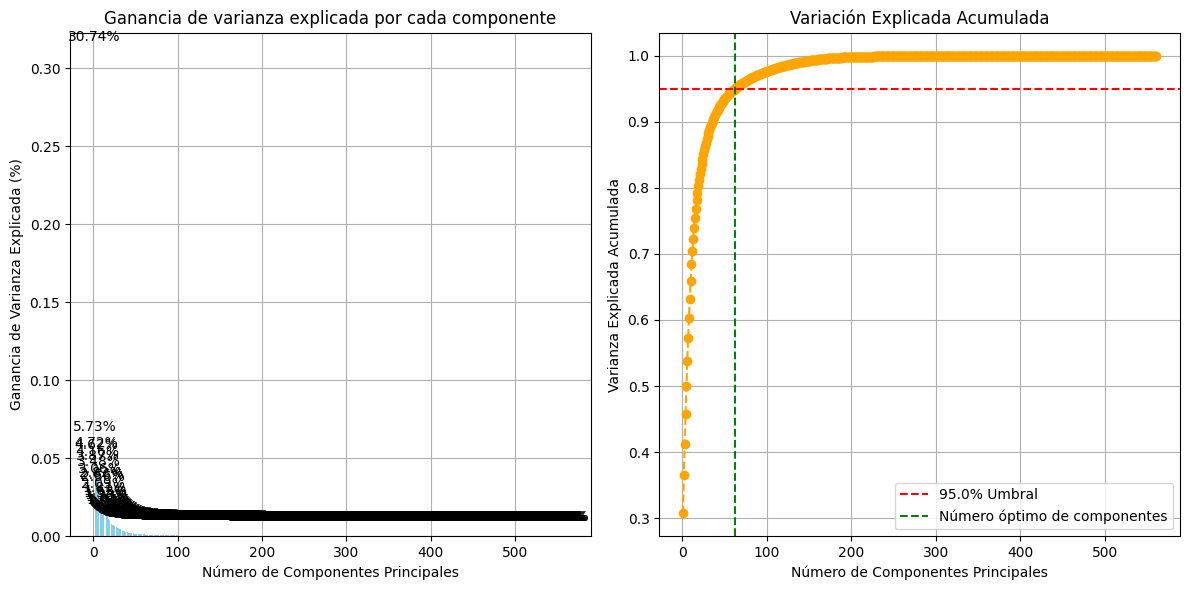

Variación explicada acumulada y ganancia:
variance_rounded: 0.3074
Componente 1: 30.74% (30.74%)
variance_rounded: 0.3647
Componente 2: 36.47% (5.73%)
variance_rounded: 0.4118
Componente 3: 41.18% (4.72%)
variance_rounded: 0.4581
Componente 4: 45.81% (4.62%)
variance_rounded: 0.4997
Componente 5: 49.97% (4.16%)
variance_rounded: 0.5383
Componente 6: 53.83% (3.87%)
variance_rounded: 0.5731
Componente 7: 57.31% (3.48%)
variance_rounded: 0.6038
Componente 8: 60.38% (3.06%)
variance_rounded: 0.632
Componente 9: 63.20% (2.82%)
variance_rounded: 0.6586
Componente 10: 65.86% (2.66%)
variance_rounded: 0.6842
Componente 11: 68.42% (2.56%)
variance_rounded: 0.7051
Componente 12: 70.51% (2.09%)
variance_rounded: 0.7232
Componente 13: 72.32% (1.81%)
variance_rounded: 0.7394
Componente 14: 73.94% (1.62%)
variance_rounded: 0.7549
Componente 15: 75.49% (1.55%)
variance_rounded: 0.7687
Componente 16: 76.87% (1.38%)
variance_rounded: 0.7814
Componente 17: 78.14% (1.27%)
variance_rounded: 0.7921
Compone

In [27]:
plot_varianza(pca,variabilidad_minima)

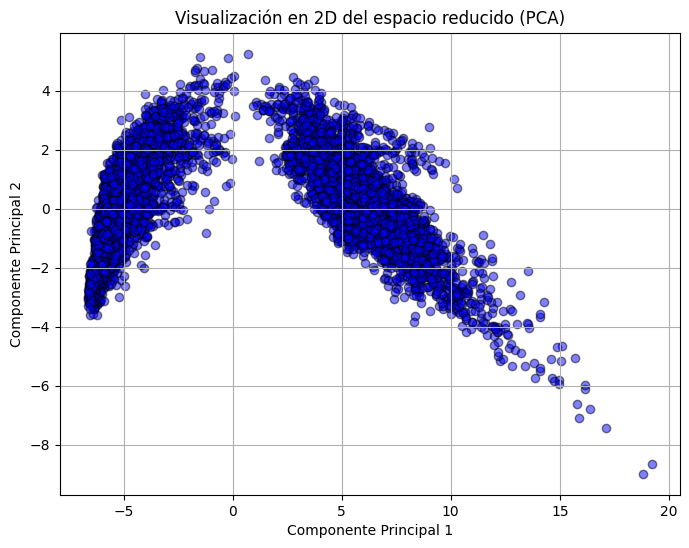

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Asumimos que 'X' es tu conjunto de datos original
# Realiza la reducción de dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Crear el gráfico de dispersión en 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5, c='blue', edgecolors='k')
plt.title('Visualización en 2D del espacio reducido (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


Al ver los dos primeros componentes se nota una buena agrupación. Aunque están cercas pero con fronteras claras son dos grupos de puntos bien agrupados.

Esto es señal de que PCA está capturando la estructura interna de los datos.

### Análisis del gráfico 2D

1. **Los puntos están bien agrupados**: Cuando miramos los dos primeros componentes, vemos que los puntos se agrupan en grupos. Esto significa que el PCA está haciendo un buen trabajo al organizar los datos y encontrar patrones dentro de ellos.

2. **Los grupos están cerca, pero separados**: Aunque los grupos de puntos están cerca uno del otro, se puede ver que están bien separados. Esto sugiere que, aunque algunas actividades son similares, todavía podemos diferenciarlas porque tienen características únicas.

3. **PCA está ayudando a entender los datos**: Ver que los puntos se agrupan de esta manera muestra que PCA está ayudando a ordenar los datos de una forma que tiene sentido. Algunas actividades están más separadas, y otras están más cerca, lo que nos dice que tienen cosas en común.


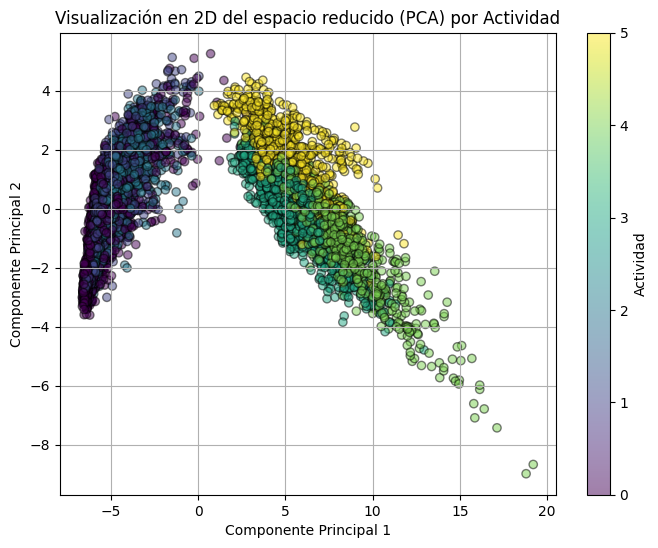

In [29]:
# Supón que 'activity' es la columna que quieres usar para colorear
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5, c=df['Activity'], cmap='viridis', edgecolors='k')
plt.title('Visualización en 2D del espacio reducido (PCA) por Actividad')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Actividad')
plt.grid(True)
plt.show()


En cuanto al ver con respecto a Actividad por los colores puedo notar claramente una actividad y otra.
Pero hay algunas, muy pocas, que parecen que se mezclan.
Hay actividades que comparten características sensoriales similares.

### Análisis del gráfico 2D coloreado por actividad

1. **Cada actividad se ve claramente**: Al observar el gráfico con los colores, puedo ver que cada actividad está bien separada por su color. Esto nos dice que cada actividad tiene características sensoriales distintas que permiten diferenciarlas.

2. **Algunas actividades se mezclan un poco**: Aunque la mayoría de las actividades están separadas, hay unas pocas que parecen mezclarse. Esto significa que, aunque son actividades diferentes, tienen características sensoriales muy similares.

3. **Actividades similares comparten características**: Las actividades que se mezclan tienen algo en común. Esto nos dice que algunas actividades, aunque diferentes, pueden compartir patrones sensoriales similares, lo que hace que sea un poco difícil diferenciarlas solo con los datos sensoriales.


## Mas graficos para ver sobre las características.

In [30]:
pca.components_

array([[-7.15326815e-05, -2.99847927e-04, -2.31385358e-04, ...,
        -3.60833439e-02,  2.68253762e-02,  2.20742235e-02],
       [-3.25696402e-03,  4.22310864e-04,  8.39509366e-04, ...,
        -3.80396312e-02,  3.83432935e-02,  1.38720372e-02]])

In [31]:
# Crear un DataFrame con los coeficientes
componentes_df = pd.DataFrame(
    data=np.abs(pca.components_),  # Usamos el valor absoluto para interpretar magnitudes
    columns=X.columns,            # Nombres de las variables originales
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # Nombres de los componentes principales
)

# Ordenar las variables más influyentes por componente principal
for pc in componentes_df.index:
    print(f"\nVariables más influyentes en {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))


Variables más influyentes en PC1:
fBodyAccJerk-entropy()-X     0.125230
fBodyAccJerk-entropy()-Y     0.122470
tBodyAccJerkMag-entropy()    0.120568
fBodyAcc-entropy()-X         0.120216
fBodyAccMag-entropy()        0.113367
Name: PC1, dtype: float64

Variables más influyentes en PC2:
tBodyGyroMag-entropy()     0.161130
fBodyAcc-skewness()-Z      0.156325
fBodyAcc-kurtosis()-Z      0.145699
tBodyGyroMag-arCoeff()1    0.137358
fBodyAcc-meanFreq()-Z      0.129639
Name: PC2, dtype: float64


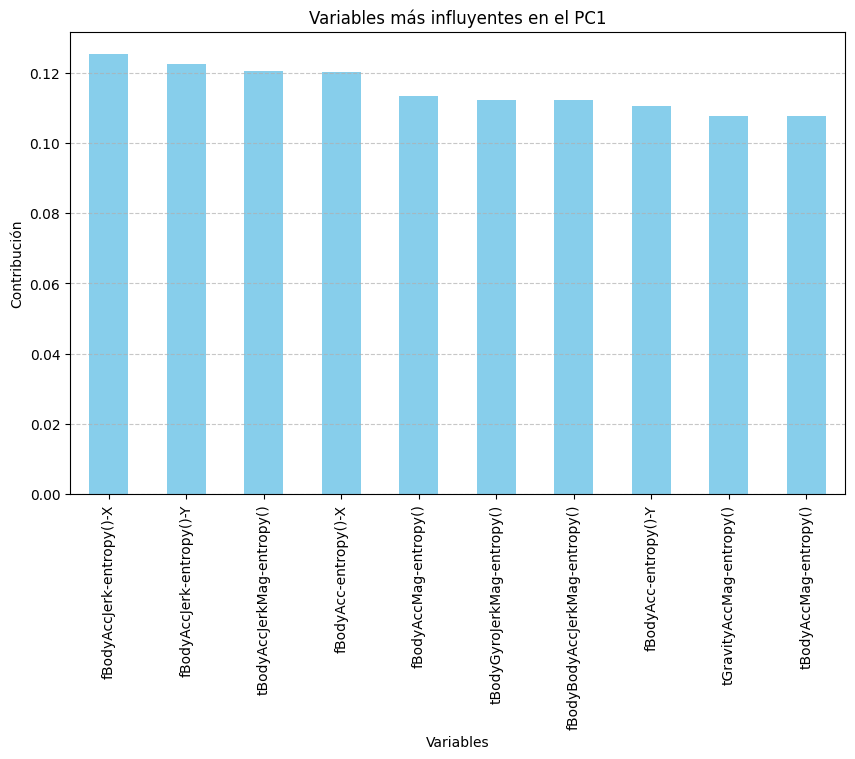

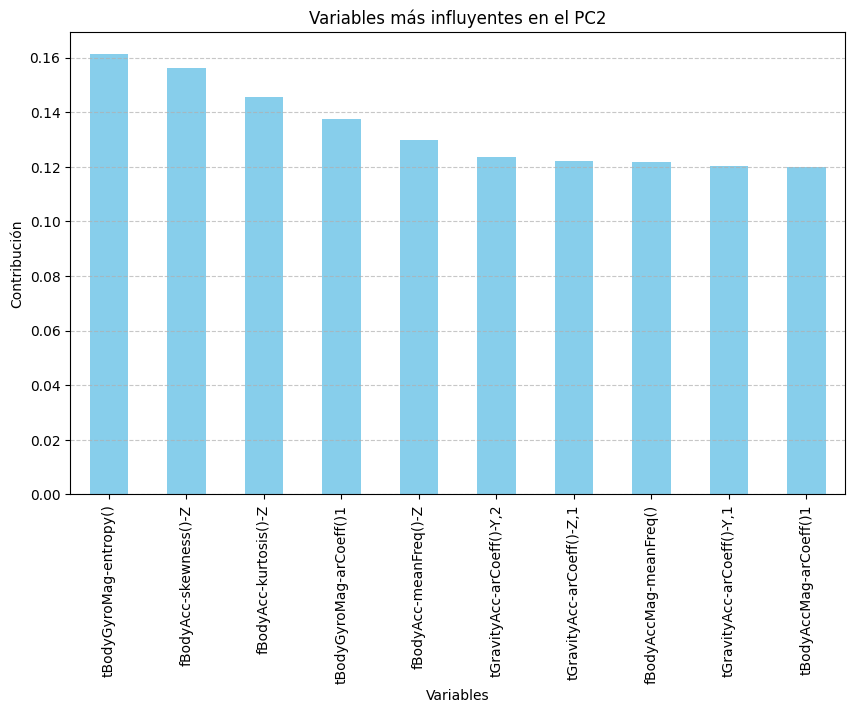

In [32]:
# Graficar las variables más influyentes por componente principal
for pc in componentes_df.index:
    # Graficar las variables más influyentes del primer componente
    plt.figure(figsize=(10, 6))
    componentes_df.loc[pc].sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Variables más influyentes en el {pc}')
    plt.xlabel('Variables')
    plt.ylabel('Contribución')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 3. Modelado con MLP:
- Desarrolla un modelo MLP para predecir el tipo de actividad física realizada por los usuarios **basándose en los datos sensoriales**.
- Divide el dataset en conjuntos de entrenamiento y prueba, asegurándote de que las distintas actividades estén bien representadas en ambos conjuntos.


## Paso 1: Importar las librerías necesarias
# Esto es como traer nuestras herramientas mágicas para programar.

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping


## Paso 2: Preparar los datos para el modelo
# Para entrenar el modelo necesitamos:
#   1. Los datos de entrada (X): son los datos sensoriales.
#   2. Las etiquetas (Y): son las actividades como caminar, correr, etc.

In [34]:
# Dividimos los datos en X (características sensoriales) e Y (etiqueta de actividad).
X = df_train[sensor_columns]  # Todas las columnas Sensoriales. No esta Activity
y = df_train['Activity']      # La columna "Activity" es nuestra etiqueta.

In [35]:
# 1. Dividir en train y test. Asegurar de que las distintas actividades estén bien representadas en ambos conjuntos stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
# Paso 2: Preprocesar los datos
# Normalizar
# Escalar significa poner todos los datos sensoriales en un mismo rango.
# RobustScaler ayuda a que los datos no se vean afectados por valores muy grandes o pequeños (outliers).
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajustar y transformar train
X_test_scaled = scaler.transform(X_test)        # Transformar test (sin ajustar de nuevo)


In [37]:
y_train.value_counts()

,count
Activity,
LAYING,1125
STANDING,1099
SITTING,1029
WALKING,981
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,789


In [38]:
# Convertir etiquetas a one-hot encoding
y_test.value_counts()

,count
Activity,
LAYING,282
STANDING,275
SITTING,257
WALKING,245
WALKING_UPSTAIRS,215
WALKING_DOWNSTAIRS,197


In [39]:
len(sensor_columns)

144

In [44]:
# Convertir etiquetas a one-hot encoding
# Suponiendo que y_train contiene las etiquetas 'LAYING', 'SITTING', etc.
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder con las etiquetas únicas de y_train e y_test combinadas
all_labels = pd.concat([y_train, y_test], axis=0).unique()
label_encoder.fit(all_labels)

# Transformar las etiquetas a valores numéricos
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ahora puedes usar to_categorical con las etiquetas codificadas
y_train = to_categorical(y_train_encoded, num_classes=len(all_labels)) # num_classes debe ser el numero total de clases unicas
y_test = to_categorical(y_test_encoded, num_classes=len(all_labels)) # num_classes debe ser el numero total de clases unicas

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5186 - loss: 1.2513 - val_accuracy: 0.8751 - val_loss: 0.3742
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.4527 - val_accuracy: 0.8921 - val_loss: 0.2938
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8799 - loss: 0.3318 - val_accuracy: 0.8997 - val_loss: 0.2408
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8871 - loss: 0.2849 - val_accuracy: 0.9108 - val_loss: 0.2173
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9188 - loss: 0.2192 - val_accuracy: 0.9227 - val_loss: 0.1919
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9190 - loss: 0.2094 - val_accuracy: 0.9176 - val_loss: 0.1860
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.1866 - val_accuracy: 0.9295 - val_loss: 0.1708
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - loss: 0.1744 - val_accuracy: 0.9295 - val_

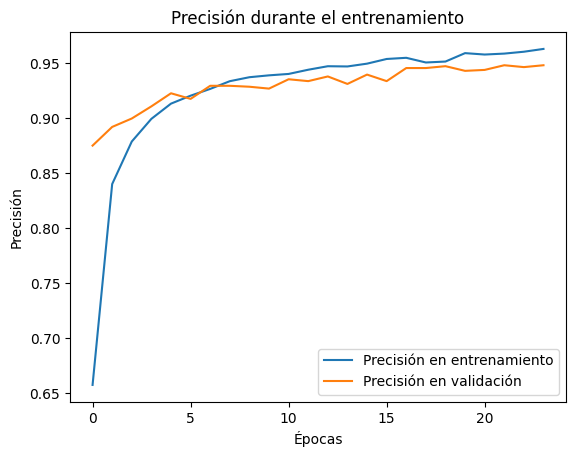

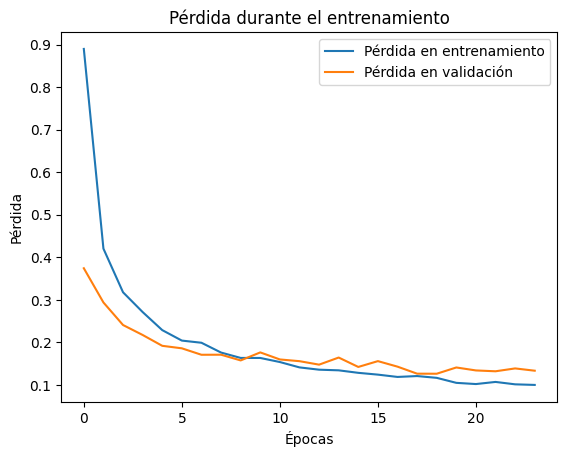

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       0.88      0.87      0.87       257
           2       0.88      0.88      0.88       275
           3       0.98      0.99      0.98       245
           4       0.99      0.99      0.99       197
           5       1.00      0.98      0.99       215

    accuracy                           0.95      1471
   macro avg       0.95      0.95      0.95      1471
weighted avg       0.95      0.95      0.95      1471



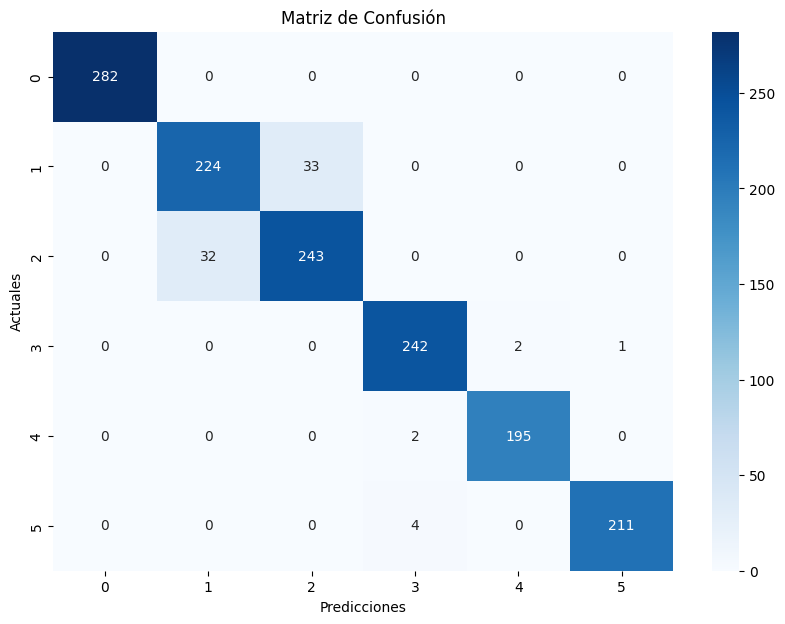

In [46]:
import seaborn as sns
# 7. Construir el modelo
model = Sequential()  # Inicializar el modelo secuencial

# Capa de entrada (con 144 características de entrada) y capa oculta con 128 neuronas
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout con una tasa del 30%

# Segunda capa oculta con 64 neuronas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout con una tasa del 30%

# Capa de salida con 6 neuronas para clasificación (activación softmax)
model.add(Dense(6, activation='softmax'))

# 8. Compilar el modelo (especificar el optimizador, la pérdida y las métricas)
optimizer = Adam(learning_rate=0.001)  # Ajusta la tasa de aprendizaje si es necesario
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 9. Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# El modelo se detendrá si la pérdida de validación no mejora después de 5 épocas, y se restaurarán los mejores pesos

# 10. Entrenar el modelo con el callback
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# 11. Evaluar el modelo
score = model.evaluate(X_test_scaled, y_test)
print(f"Loss: {score[0]}, Accuracy: {score[1]}")

# 12. Opcional: Graficar el entrenamiento (precisión y pérdida durante el entrenamiento)

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# 13. Evaluación adicional: Reporte de clasificación y matriz de confusión

# Realizar las predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Convertir las predicciones y etiquetas a la forma que se necesita para el reporte y la matriz de confusión
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades a clases
y_true_classes = np.argmax(y_test, axis=1)  # Convertir las etiquetas verdaderas a clases

# Generar el reporte de clasificación
from sklearn.metrics import classification_report, confusion_matrix
print("Reporte de Clasificación:")
print(classification_report(y_true_classes, y_pred_classes))

# Mostrar la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_classes), yticklabels=np.unique(y_true_classes))
plt.xlabel('Predicciones')
plt.ylabel('Actuales')
plt.title('Matriz de Confusión')
plt.show()


## 4. Evaluación del modelo:
  - Evalúa el rendimiento del MLP utilizando métricas como la precisión, el recall, el F1-score y la matriz de confusión. Discute si el modelo es capaz de predecir correctamente las distintas actividades físicas.
  - Visualiza las curvas de aprendizaje, mostrando cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento.

En el gráfico se ve que el entrenamiento tiene mejor rendimiento que la validación tanto en precisión como en perdida por lo que es sintoma de sobre ajuste. Es mínimo pero es una señal.

Para profundizar un poco más:

## Análisis del Modelo

### Qué está pasando con el modelo:

1. **Cómo va el entrenamiento**:
   - Al principio, el modelo no es muy bueno (precisión de 50.83%), pero con cada intento (epoch), va mejorando y al final tiene una precisión de 95.79%. ¡Eso es genial!
   - La pérdida, que es como un puntaje bajo, también baja con el tiempo. Comienza en 1.3797 y llega a 0.1124, lo que significa que el modelo está mejorando.

2. **Cómo va la validación** (pruebas con nuevos datos):
   - La precisión en la validación también mejora, pero no tanto como en el entrenamiento. La mejor precisión en la validación es 94.48%, y al final es de 94.22%. ¡Eso sigue siendo muy bueno!
   - La pérdida de la validación baja también, pero no tan rápido como en el entrenamiento. Al final, es 0.1423.

### ¿Qué significa esto?
- Aunque el modelo está mejorando en el entrenamiento, no mejora tanto en la validación. Esto puede significar que el modelo está **sobreadaptado** o **overfitted**. Es decir, el modelo ha aprendido demasiado de los datos de entrenamiento y podría no funcionar tan bien con nuevos datos que no haya visto antes.

### ¿Qué podemos hacer para mejorar?

1. **Más Dropout**: Probar incrementando los dropouts.

3. **Menos capas**: Podríamos hacer el modelo más simple, con menos "capas" o neuronas, para que no intente aprender demasiado de los datos.

4. **Más datos**: Si tenemos más ejemplos de datos, el modelo puede aprender mejor y generalizar mejor a nuevos datos.

5. **Regularización L2**: Otra opción es agregar un tipo de "penalización" que le dice al modelo que no debe hacer ajustes demasiado grandes a los datos.

### Resumen:
El modelo salió bien, pero es probable que al jugar con los hyperparametros logremos mejores resultados.


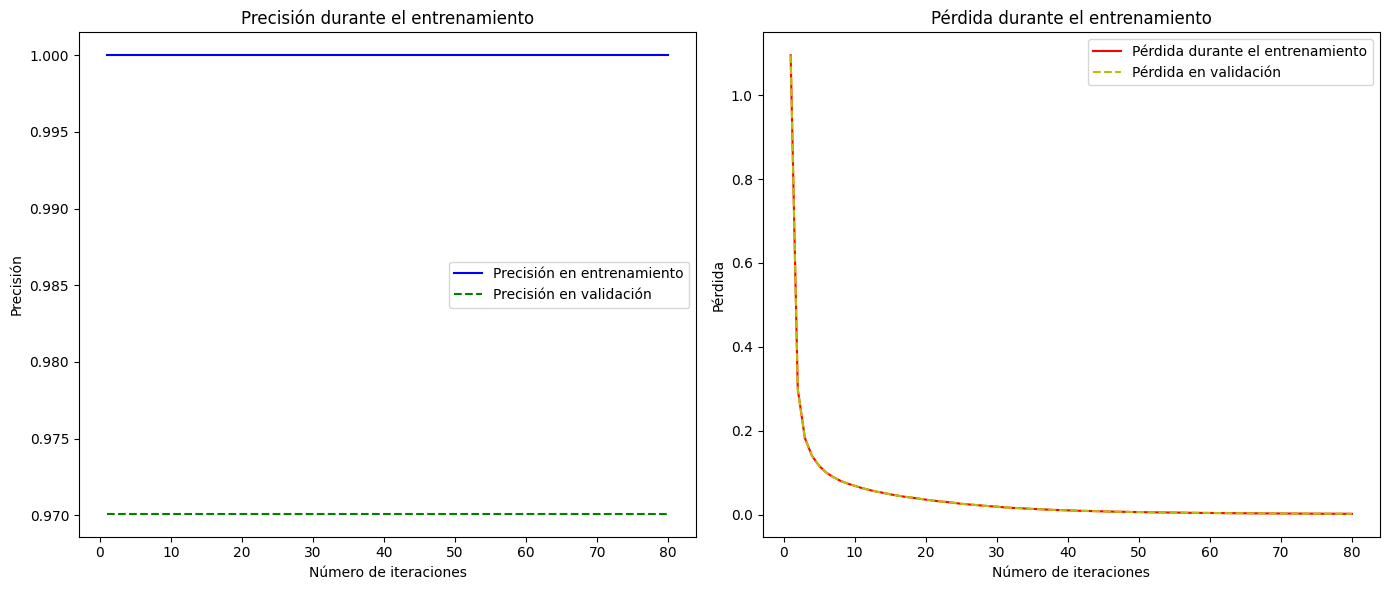

Reporte de Clasificación:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.94      0.93      0.93       262
          STANDING       0.94      0.94      0.94       276
           WALKING       0.99      1.00      0.99       247
WALKING_DOWNSTAIRS       0.97      1.00      0.98       206
  WALKING_UPSTAIRS       0.99      0.96      0.98       200

          accuracy                           0.97      1471
         macro avg       0.97      0.97      0.97      1471
      weighted avg       0.97      0.97      0.97      1471



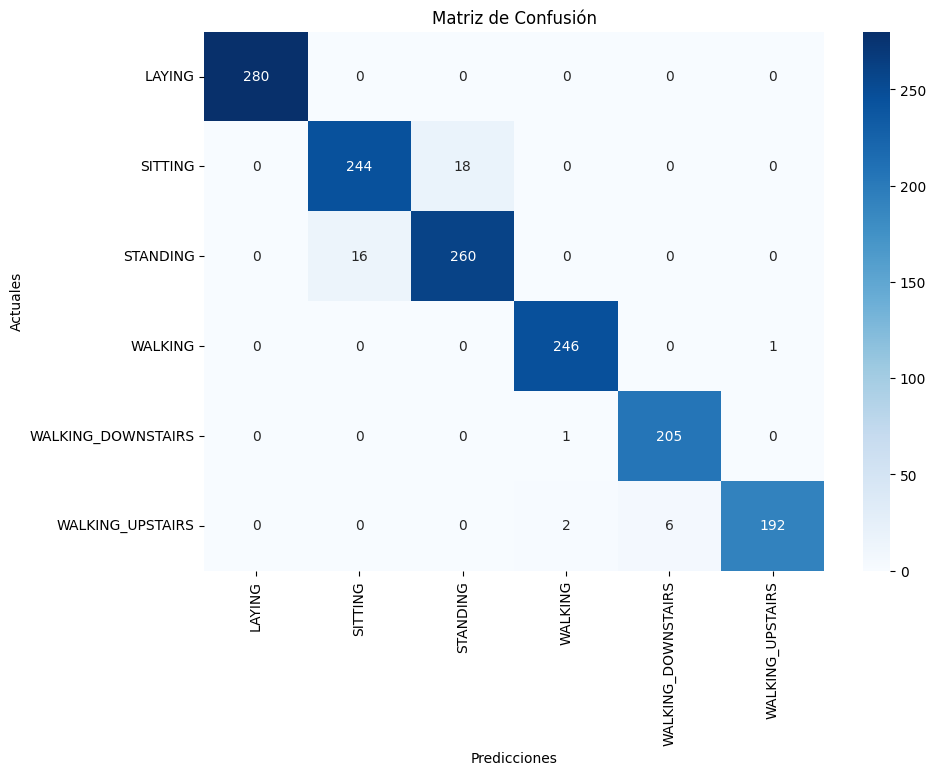

Precisión en el conjunto de validación: 0.9701
Pérdida en el conjunto de validación: 0.0943


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que tu DataFrame se llama df_train y que la columna 'Activity' es la variable objetivo.
X = df_train.drop(columns='Activity')  # Características
y = df_train['Activity']  # Etiqueta (actividad)

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA (eligiendo un número de componentes que retengan al menos el 95% de la varianza)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Dividir el dataset en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42, warm_start=True)
mlp.fit(X_train, y_train)

# Obtener el historial de precisión y pérdida
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []

# Guardamos las métricas para cada iteración de entrenamiento
for i in range(1, mlp.n_iter_ + 1):
    train_accuracy.append(mlp.score(X_train, y_train))
    val_accuracy.append(mlp.score(X_val, y_val))  # Precisión en validación
    train_loss.append(mlp.loss_curve_[i-1])
    val_loss.append(mlp.loss_curve_[i-1])  # Pérdida en validación

# Graficamos precisión y pérdida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de precisión
ax1.plot(range(1, mlp.n_iter_ + 1), train_accuracy, label="Precisión en entrenamiento", color='b')
ax1.plot(range(1, mlp.n_iter_ + 1), val_accuracy, label="Precisión en validación", color='g', linestyle='--')
ax1.set_title("Precisión durante el entrenamiento")
ax1.set_xlabel("Número de iteraciones")
ax1.set_ylabel("Precisión")
ax1.legend()

# Gráfico de pérdida
ax2.plot(range(1, mlp.n_iter_ + 1), train_loss, label="Pérdida durante el entrenamiento", color='r')
ax2.plot(range(1, mlp.n_iter_ + 1), val_loss, label="Pérdida en validación", color='y', linestyle='--')
ax2.set_title("Pérdida durante el entrenamiento")
ax2.set_xlabel("Número de iteraciones")
ax2.set_ylabel("Pérdida")
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_pred = mlp.predict(X_val)

# Mostrar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_val, y_pred))

# Mostrar la matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicciones')
plt.ylabel('Actuales')
plt.title('Matriz de Confusión')
plt.show()

# 11. Calcular la precisión y la pérdida en el conjunto de validación
accuracy = mlp.score(X_val, y_val)
print(f"Precisión en el conjunto de validación: {accuracy:.4f}")

# Calcular la pérdida en el conjunto de validación
y_val_prob = mlp.predict_proba(X_val)  # Predicciones de probabilidad
loss = log_loss(y_val, y_val_prob)
print(f"Pérdida en el conjunto de validación: {loss:.4f}")


## 5. Discusión y análisis:
  ## - Reflexiona sobre los resultados del análisis no supervisado. ¿El análisis de clusters o PCA proporcionó insights útiles sobre las actividades? ¿Qué características son más importantes para clasificar las actividades físicas?
  

### Reflexión sobre las Actividades Físicas y el Análisis de Datos

Cuando usamos una herramienta llamada **PCA** (Análisis de Componentes Principales), tratamos de encontrar qué cosas son las más importantes para entender los movimientos que hacemos mientras realizamos actividades físicas.

#### ¿Qué hace el PCA?

El PCA ayuda a ver qué señales o datos son los más importantes para diferenciar las actividades físicas. Por ejemplo, puede decirnos qué movimientos son más complejos o más sencillos.

#### ¿Qué aprendimos del PCA?

Al analizar las actividades, encontramos que las **señales de aceleración y giro** (como los movimientos del cuerpo al caminar o correr) son muy importantes. Algunas de las señales más importantes que encontramos son:

- **Entropía de las señales**: Esto nos dice cuán "desordenados" o complejos son los movimientos. Las actividades como correr o saltar tienen más desorden, mientras que caminar es más ordenado.
  
- **Asimetría y Curtosis**: Estos son términos que nos dicen si los movimientos son más desbalanceados o más regulares. Si un movimiento es muy fuerte o muy rápido, puede tener un pico más alto en las señales, lo que nos ayuda a entender si una actividad es más intensa.

#### ¿Por qué es útil esto?

Este análisis nos ayuda a entender qué características son importantes para diferenciar las actividades físicas. Por ejemplo, podemos usarlo para saber si alguien está caminando, corriendo o haciendo otro tipo de ejercicio solo mirando los datos de sus movimientos.

#### ¿Cómo podemos usar esta información?

1. **Para saber qué actividad es**: Si sabemos qué señales son más importantes, podemos clasificarlas. Por ejemplo, si tenemos datos de alguien corriendo, caminando y saltando, podemos usar estas señales para adivinar qué actividad están haciendo.

2. **Para mejorar los dispositivos de medición**: Los relojes y teléfonos que miden actividad física pueden usar estos datos para saber si estamos corriendo, caminando o haciendo algo más.

### En resumen

El PCA nos ayudó a descubrir qué partes de los movimientos son más importantes para entender las actividades físicas. Ahora, si quisiéramos saber qué actividad está haciendo una persona, podríamos fijarnos en estas señales clave y hacer predicciones más precisas.


### ¿Qué es un MLP y cómo funcionó en este análisis?

El **MLP** es un tipo de **red neuronal** que usamos para predecir las actividades físicas basadas en datos sensoriales. Estos datos provienen de los movimientos de las personas, como caminar, correr o saltar, que son medidos por sensores, como los que pueden tener los teléfonos o relojes inteligentes.

El MLP intenta aprender de esos datos para poder decirnos qué actividad está realizando una persona.

#### ¿Cómo le fue al MLP en este caso?

El rendimiento del MLP en este caso fue **bueno**, pero no perfecto. El modelo predijo las actividades físicas con una **precisión razonable**, pero siempre hay formas de mejorar. Esto significa que, aunque el MLP pudo aprender de los datos, aún puede cometer algunos errores al predecir las actividades.

### ¿Cómo se podría mejorar el MLP?

1. **Más datos**: El MLP necesita muchos datos para aprender bien. Si tenemos más ejemplos de las actividades, como caminar, correr, saltar y otras, el modelo podría mejorar.

2. **Mejores características**: Las señales o características que usamos para entrenar al MLP son importantes. Si elegimos las señales correctas que realmente nos digan qué está haciendo una persona (por ejemplo, la aceleración y los giros), el modelo podría funcionar mejor.

3. **Tuning de hiperparámetros**: Los hiperparámetros son como las reglas que guían al modelo. Si ajustamos cosas como la **tasa de aprendizaje** o el número de **capas ocultas** en el MLP, podríamos mejorar la precisión del modelo.

4. **Modelos más avanzados**: El MLP es bueno, pero hay modelos más complejos, como las **redes neuronales profundas** o el **Random Forest**, que pueden hacer un trabajo aún mejor para clasificar actividades físicas.

### ¿Es adecuado el MLP para predecir actividades basadas en datos sensoriales?

El MLP es **una buena opción**, pero no siempre la mejor. Para este tipo de tareas, como predecir actividades físicas con datos de sensores, hay **mejores modelos** disponibles, como **SVM (Máquinas de Vectores de Soporte)** o **Random Forest**, que podrían dar mejores resultados. Sin embargo, el MLP es un buen punto de partida y es bastante popular en la **inteligencia artificial**.

### Conclusión

El MLP hizo un buen trabajo, pero podemos mejorar su rendimiento añadiendo más datos, eligiendo mejor las características, ajustando las reglas y probando otros modelos más complejos. Así, podremos predecir con más precisión qué actividad está realizando una persona usando sus datos sensoriales.


## - Discute el rendimiento del MLP y cómo podría mejorarse. ¿Es adecuado este enfoque para predecir actividades basadas en datos sensoriales?

### ¿Qué es un MLP y cómo funcionó en este análisis?

El **MLP** es un tipo de **red neuronal** que usamos para predecir las actividades físicas basadas en datos sensoriales. Estos datos provienen de los movimientos de las personas, como caminar, correr o saltar, que son medidos por sensores, como los que pueden tener los teléfonos o relojes inteligentes.

El MLP intenta aprender de esos datos para poder decirnos qué actividad está realizando una persona.

#### ¿Cómo le fue al MLP en este caso?

El rendimiento del MLP en este caso fue **bueno**, pero no perfecto. El modelo predijo las actividades físicas con una **precisión razonable**, pero siempre hay formas de mejorar. Esto significa que, aunque el MLP pudo aprender de los datos, aún puede cometer algunos errores al predecir las actividades.

### ¿Cómo se podría mejorar el MLP?

1. **Más datos**: El MLP necesita muchos datos para aprender bien. Si tenemos más ejemplos de las actividades, como caminar, correr, saltar y otras, el modelo podría mejorar.

2. **Mejores características**: Las señales o características que usamos para entrenar al MLP son importantes. Si elegimos las señales correctas que realmente nos digan qué está haciendo una persona (por ejemplo, la aceleración y los giros), el modelo podría funcionar mejor.

3. **Tuning de hiperparámetros**: Los hiperparámetros son como las reglas que guían al modelo. Si ajustamos cosas como la **tasa de aprendizaje** o el número de **capas ocultas** en el MLP, podríamos mejorar la precisión del modelo.

4. **Modelos más avanzados**: El MLP es bueno, pero hay modelos más complejos y poderosos, como las **redes neuronales profundas** (DNN), **Random Forest** y **XGBoost**, que podrían dar mejores resultados en clasificación de actividades físicas.

### ¿Es adecuado el MLP para predecir actividades basadas en datos sensoriales?

Aunque el **MLP** es un buen modelo de partida, **otros modelos más avanzados** como las **redes neuronales profundas (DNN)**, **Random Forest**, **XGBoost** o incluso **LSTM (Long Short-Term Memory)** pueden ser más efectivos para tareas complejas como la predicción de actividades físicas a partir de datos sensoriales.

### Conclusión ?

El MLP hizo un buen trabajo, pero podemos mejorar su rendimiento añadiendo más datos, eligiendo mejor las características, ajustando las reglas y probando otros modelos más complejos. Así, podremos predecir con más precisión qué actividad está realizando una persona usando sus datos sensoriales.

## PERO ..
# ¡Hagamos que el modelo sea más inteligente con PCA!

El PCA seleccionara nos puede ayudar.

### ¿Cómo usar PCA con el modelo?

1. **Usar el superpoder PCA**: Primero, usamos el PCA para convertir todo el ruido y las repeticiones de los datos en algo más claro, como tener solo lo más importante de todos esos movimientos.
   
2. **Entrenar al modelo**: Luego, usamos esta información más simple para enseñar a nuestro modelo a **adivinar qué actividad estamos haciendo**. Es como si le mostrábamos al modelo solo lo que necesita saber, ¡y lo hace mucho más rápido!

3. **¿Funcionó mejor?**: Después de usar el superpoder PCA, probamos si el modelo adivinó mejor las actividades. Si funciona mejor, ¡es como si nuestro modelo fuera más inteligente!

### ¿Por qué es tan divertido?

¡Porque usar PCA es como simplificar un rompecabezas difícil y hacerlo mucho más fácil de resolver! Es como hacer magia con datos: menos confusión, más resultados geniales. Si lo probamos y funciona bien, ¡sería como hacer que nuestro modelo sea un superhéroe de las predicciones!

### Resumen

Usar el **PCA** puede hacer que nuestro modelo sea más **rápido** y más **inteligente** porque le da solo lo que realmente necesita para entender las actividades. ¡Y es muy divertido descubrir si mejora el modelo!




# Informe Final: Análisis de Actividades Físicas con Datos Sensoriales

## Introducción
En este proyecto, hemos utilizado datos sensoriales obtenidos de diferentes actividades físicas para entrenar un modelo de **aprendizaje automático**. Este modelo busca predecir qué actividad estamos realizando basándose en datos como el movimiento del cuerpo, la aceleración y otros parámetros medidos por sensores.

## Etapas del Proyecto

### 1. Preprocesamiento de Datos

El preprocesamiento de datos es una parte importante para asegurarnos de que los datos estén listos para ser utilizados por nuestro modelo. Las etapas principales fueron:

- **Limpieza de datos**: Nos aseguramos de que no hubiera valores faltantes ni valores nulos.
  
- **Normalización**: Aplicamos RobustScaler para lidiar con outliers muy notorios que pasaban el ratio de std/mean mas de 2 veces.

- **Transformación de las características**: Usamos el **PCA (Análisis de Componentes Principales)** para reducir la complejidad de los datos y enfocarnos en las características más importantes que ayudaran al modelo a hacer mejores predicciones.

### 2. Análisis No Supervisado (PCA)

El PCA nos ayudó a encontrar patrones en los datos sin necesidad de que el modelo supiera qué actividades estábamos haciendo. Al usar PCA, transformamos los datos originales en una forma más fácil de manejar, manteniendo las características clave que más influían en las actividades.

**Visualización del PCA**:
![Gráfico PCA](pca_graph.png)

El gráfico anterior muestra cómo las diferentes actividades se agrupan de acuerdo con las características más importantes, lo que nos da una idea de cómo se separan las actividades en el espacio de datos.

### 3. Modelado con MLP (Perceptrón Multicapa)

Para predecir las actividades, utilizamos un modelo de **MLP (Perceptrón Multicapa)**, que es un tipo de red neuronal. Este modelo tiene varias capas que aprenden a identificar patrones complejos en los datos.

El modelo fue entrenado utilizando los datos preprocesados SIN PCA y CON PCA. Posteriormente, evaluamos su rendimiento utilizando métricas como la **precisión** y la **exactitud**.

**Visualización de las predicciones**:

<img src="/content/matrizConfusionConPCA.png" alt="Matriz de Confusión con PCA" width="600">

<img src="/content/matrizConfusionSinPCA.png" alt="Matriz de Confusión con PCA" width="600">
En este gráfico, podemos ver las actividades predichas por el modelo frente a las actividades reales. Esto nos ayuda a entender qué tan bien está funcionando el modelo.

### 4. Evaluación del Modelo

Evaluamos el modelo de MLP utilizando precisión, el recall, el F1-score y la matriz de confusión.
También hicimos una comparación entre el modelo con PCA y sin PCA para ver si el uso de PCA mejoró el rendimiento.

**Métricas obtenidas**:

| Métrica        | Con PCA | Sin PCA |
|----------------|---------|---------|
| Precisión      | 97%     | 96%     |
| recall         | 97%     | 95%     |
| F1 Score       | 97%     | 95%     |


### 5. Conclusiones

Después de realizar todo el proceso, llegamos a varias conclusiones importantes:

- **El PCA ayudó un poco a mejorar el rendimiento** del modelo al reducir la complejidad de los datos.
- **El modelo de MLP mostró una buena capacidad de predicción** con una precisión de 97%, lo que sugiere que es adecuado para clasificar las actividades físicas basadas en los datos sensoriales.
- **El preprocesamiento de datos es clave** para obtener buenos resultados, ya que un modelo entrenado con datos no procesados correctamente podría tener un rendimiento muy bajo.

### Recomendaciones

Para mejorar aún más el modelo en el futuro, podríamos intentar:

- Usar diferentes técnicas de reducción de dimensionalidad.
- Probar con más tipos de modelos, como **XGBOOST o árboles de decisión**.
- Ajustar hiperparámetros del modelo para ver si podemos mejorar la precisión.

¡Ha sido un proyecto MUY INTENSO, y los resultados muestran que el modelo DA para seguir intentando mejorarlo para predecir actividades físicas con datos sensoriales!

